In [1]:
import Pkg; Pkg.add(["Plots", "Interact"]);
import Logging; Logging.disable_logging(Logging.Info)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Project.toml`
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Manifest.toml`


LogLevel(1)

In [2]:
const STATIC_LECTURE = false;

In [3]:
using LinearAlgebra;
using Plots; default(l=5, size=(900,550), label=false);
using Printf;
using Interact;

BLAS.set_num_threads(1)

default(fmt=:png)

prettyprint(a) = map(x -> @sprintf("%+.2f", x), v)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=:diverging_gwv_55_95_c39_n256
        ; kwargs...
    )
end

WebIO._IJuliaInit()

imshow (generic function with 1 method)

### Warmup

> If a problem $Ax = b$ contains an ill-conditioned matrix $A$, one must always expect to "lose $\log_{10} \kappa(A)$ digits" in computing the solution

Write a julia snippet to demonstrate this fact.

1. Choose $\kappa$
2. Create a random matrix $A$ with exactly that condition number (use the SVD and $\kappa(A) = \sigma_1 / \sigma_m$).
3. Create a random true solution $x$
4. Multiply them together to create $b \gets Ax$
5. Compute $\hat{x} \gets A^{-1} b$
6. Measure the relative error $\| x - \hat{x} \| / \|x\|$

1.0000000000000009

0.18921691697560838

# Floating Point Arithmetic & Stability

## Floating Point Numbers

### Fixed-size approximations of real numbers are necessary for numerical computing

Computers can be much faster when numbers are a fixed size in memory:

- Predictable space requirements
- Predictable time requirements
- Specialized circuitry for the most important operations

- `Float64` = 64 bits = 8 bytes

- `Float32` = 32 bits = 4 bytes

- `Float16` = 16 bits = 2 bytes

In [5]:
sizeof.([Float64 Float32 Float16])

1×3 Matrix{Int64}:
 8  4  2

### Race: lossless matrix inversion vs. rounding error matrix inversion

Exact rational arithmetic:

- Growing space as operations compound
- Operations take multiple basic machine instructions to complete

In [6]:
m = 100
Abr = zeros(Rational{BigInt}, m,m)
for i in 1:m
    Abr[i,i] = 2
    if i < m
        Abr[i,i+1] = -1
        Abr[i+1,i] = -1
    end
end

In [7]:
m = 100
Afl = zeros(Float64, m,m)
for i in 1:m
    Afl[i,i] = 2
    if i < m
        Afl[i,i+1] = -1
        Afl[i+1,i] = -1
    end
end

In [8]:
@time Abr^-1;

  3.705676 seconds (21.49 M allocations: 769.375 MiB, 17.94% gc time, 40.75% compilation time)


In [9]:
@time Afl^-1;

  0.005094 seconds (553 allocations: 164.262 KiB, 88.00% compilation time)


### "Floating point" contrasts with "Fixed point"

**Fixed point:** equally spaced fractions up to some maximum scale
  - Good for _absolute errors_ in _normalized calculations_ (revived interest: neural network weights)

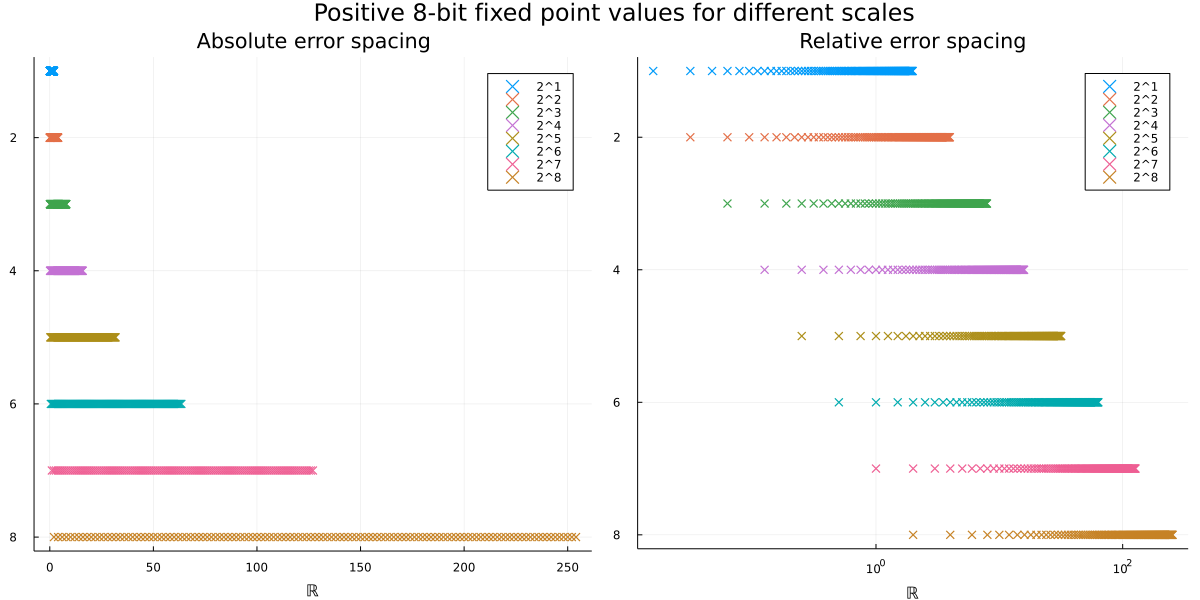

In [10]:
function fixed_point_bytes(scale)
    return collect(LinRange(-scale, scale*(127 / 128), 256))
end
p = plot(xlabel = "ℝ", yflip = true, title = "Absolute error spacing")
for i = 1:8
    V = filter(x -> x > 0., fixed_point_bytes(2.0^i))
    plot!(p, V
        , i * ones(length(V))
        , line=nothing
        , marker=:x
        , label = "2^$i"
    )
end;
q = plot(xlabel = "ℝ", yflip = true, title = "Relative error spacing", xscale=:log10)
for i = 1:8
    V = filter(x -> x > 0., fixed_point_bytes(2.0^i))
    plot!(q, V
        , i * ones(length(V))
        , line=nothing
        , marker=:x
        , label = "2^$i"
    )
end
plot(p, q, layout=(1,2)
    , plot_title = "Positive 8-bit fixed point values for different scales"
    , size=(1200,600)
    , bottom_margin=3Plots.mm
)


**Floating point:** (base 2)

$$\underbrace{\strut \pm}_{\strut\text{sign bit}} \underbrace{\strut 1.m_2}_{\strut\  m\ = \text{ fraction}} \cdot \underbrace{\strut 2^e}_{\strut\ e\ = \text{ exponent}}, \quad \text{(stored as }[\pm,m,e]\text{)}$$

- Compare to _scientific notation_:

$$-8.5 \times 10^{-5}$$

- Good for _relative errors_
- The hard part: deciding how to divide the bits between $[\pm,m,e]$
- We will call the set of all floating point numbers $\mathbf{F}$

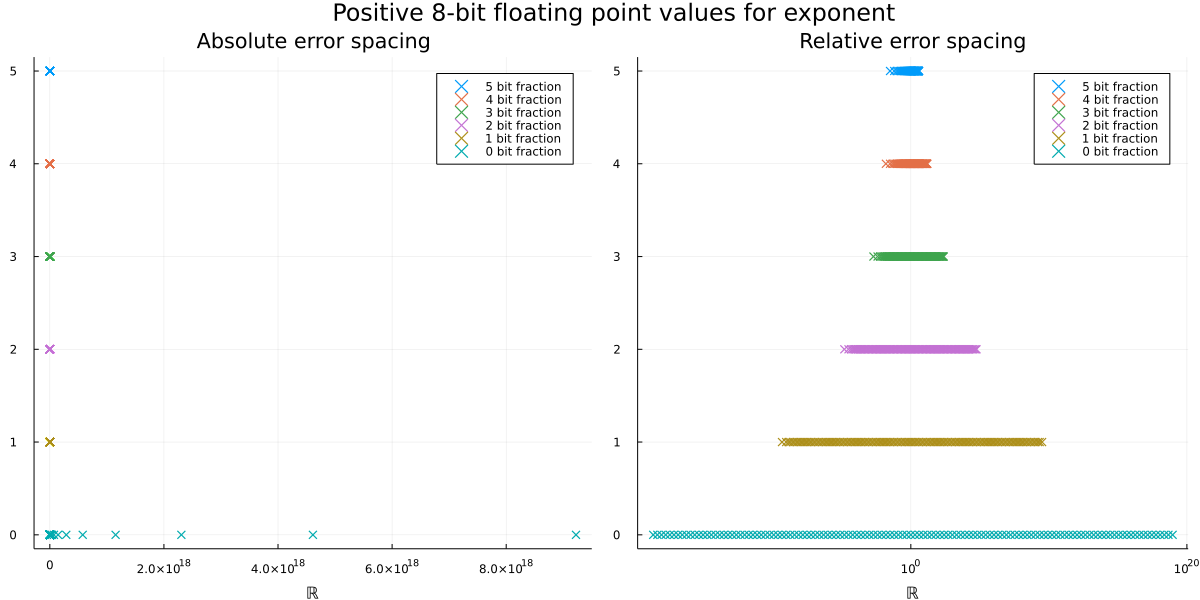

In [11]:
function floating_point_bytes(exponent_digits)
    @assert exponent_digits >= 2 && exponent_digits <= 7
    mantissa_digits = 7 - exponent_digits
    e_max = 2^(exponent_digits - 1) - 1
    e_min = 1 - e_max
    bias = e_max
    V = Vector{Float64}(undef, 0)
    for sign in [-1, 1.]
        # subnormal numbers
        for mantissa in 0:2^mantissa_digits - 1
            frac = mantissa / 2^mantissa_digits
            push!(V, sign * 2. ^e_min * frac)
        end
        # normal numbers
        for ex in e_min:e_max
            for mantissa in 0:2^mantissa_digits - 1
                frac = (2^mantissa_digits + mantissa) / 2^mantissa_digits
                push!(V, sign * 2. ^ex * frac)
            end
        end
    end
    return sort(V)
end
p = plot(xlabel = "ℝ", title = "Absolute error spacing")
for i = 2:7
    V = filter(x -> x > 0., floating_point_bytes(i))
    plot!(p, V
        , (7-i) * ones(length(V))
        , line = nothing
        , marker = :x
        , label = "$(7-i) bit fraction"
    )
end
q = plot(xlabel = "ℝ", title = "Relative error spacing", xscale=:log10)
for i = 2:7
    V = filter(x -> x > 0., floating_point_bytes(i))
    plot!(q, V
        , (7-i) * ones(length(V))
        , line = nothing
        , marker = :x
        , label = "$(7-i) bit fraction"
    )
end
plot(p, q, layout=(1,2)
    , plot_title = "Positive 8-bit floating point values for exponent"
    , size=(1200,600)
    , bottom_margin=3Plots.mm
)

- In this class we pretend going off the ends (_underflow_ and _overflow_) doesn't happen
- We are very concerned the the _relative error of approximation (projection)_ implied by the spacing between representable numbers:

$$\text{for all }x, \quad \frac{|x - \mathrm{fl}(x)|}{|x|} \leq \mathbf{u}_{\mathbf{F}}, \quad \text{(pronounced "rounding unit")}$$

In [12]:
@manipulate for i = 2:7
    q = plot(xlabel = "ℝ", title = "u_F = $(2.0^-(8-i))", xscale=:log10)
    V = filter(x -> x > 0., floating_point_bytes(i))
    plot!(q, V
        , zeros(length(V))
        , line = nothing
        , marker = :x
        , label = "$(7-i) bit fraction"
        , ylim =(-0.1,0.1)
    )
    plot(q)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 7, :min => 2, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
4, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/tisaac/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/tisaac/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/tisaac/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), Asset("css", nothing, "/home/tisaac/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), Asset("css", nothing, "/home/tisaac/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f52b015f6b0, Task (runnable) @0x00007f52b015f6b0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"2\",\"3\",\"4\",\"5\",\"6\",\"7\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"16136958844036281219\",\"id\":\"15086813490331343715\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"16136958844036281219\",\"id\":\"1020274972542

### Floating point arithmetic

- For every basic operation $\ast\in\{+, -, \times, \div\}$ on $\mathbb{R}$ there is a floating point operation
$\circledast\in\{\bigcirc\!\!\!\!\!+\,, \bigcirc\!\!\!\!\!-\,, \bigcirc\!\!\!\!\!\times\,, \bigcirc\!\!\!\!\!\div\,\}$ that is a rounded approximation of $\ast$:

$$\circledast: \mathbf{F} \otimes \mathbf{F} \to \mathbf{F}.$$


#### Fundamental Axiom of Floating Point Arithmetic

> There is a number $\epsilon_{\text{machine}}$ (usually $2\mathbf{u}_\mathbf{F}$) such that for all $x,y\in\mathbf{F}$
>
> $$x \circledast y = (x \ast y)(1 + \epsilon), \quad |\epsilon| \leq \epsilon_{\text{machine}}.\quad\text{(pronounced "machine epsilon")}$$
>
> "Every operation of floating point arithmetic is exact up to a relative error of size $\epsilon_{\text{machine}}$."

In [13]:
[eps() eps(Float64)]

1×2 Matrix{Float64}:
 2.22045e-16  2.22045e-16

In [14]:
eps(Float32)

1.1920929f-7

In [15]:
eps(Float16)

Float16(0.000977)

In [16]:
display(Float64(0.1) + Float64(0.2))
display(Float32(0.1) + Float32(0.6))
display(Float16(0.1) + Float16(0.7))

0.30000000000000004

0.70000005f0

Float16(0.8003)

### Thought exercise

If the difference of positive floating point numbers

$$(x \bigcirc\!\!\!\!\!\!\!-\ \,y) = (x - y)(1 + \epsilon), \quad x,y > 0, x,y\in\mathbf{F}, |\epsilon| \leq \epsilon_{\text{machine}},$$

has a small relative error, why are we worried about cancellation errors? (_Hint:_ Tuesday's lecture.)

## Stability

(Remember: _conditioning_ described the sensitivity of the problem; _stability_ decribes the sensitivity of the algorithm)

## Algorithms that approximately solve problems

$$\begin{aligned}
&f:X\to Y, &\text{(problem)} \\
&\tilde f: X \to Y. &\text{(algorithm)}
\end{aligned}$$

### Accuracy

An algorithm $\tilde{f}$ is _accurate_ if for each $x\in X$,

$$
\underbrace{\frac{\|\tilde{f}(x) - f(x)\|}{\|f(x)\|}}_{\text{relative forward error}} = O(\epsilon_{\text{machine}}).
$$

- The basic floating point arithmetic operations are accurate.

It is surprising if algorithm for an ill-conditioned problem,

$$
\frac{\|f(x + \delta x) - f(x)\|}{\|f(x)\|} \gg \frac{\|\delta x\|}{\|x\|},
$$

is accurate, because a $\delta x$ just due to floating point rounding has $\|\delta x\| / \|x\| = O(\epsilon_{\text{machine}}).$

### Experiment: test accuracy of Float32 subtraction (treating Float64 as exact)

(Spot the difference!)

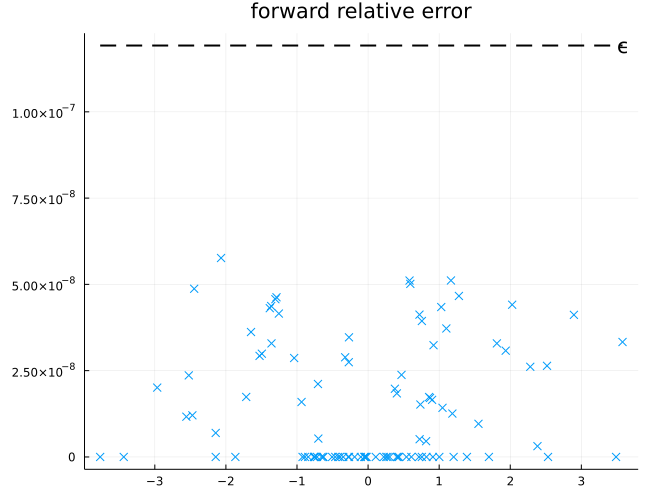

In [17]:
n_samples = 100;
x = randn(Float32, n_samples)
y = randn(Float32, n_samples)
z_true = Float64.(x) - Float64.(y)
z_fl32 = x - y
r = abs.(Float64.(z_fl32) - z_true) ./ abs.(z_true)
plot(z_true, r, st=:scatter, m=:x)
plot!([minimum(z_true),maximum(z_true)], eps(Float32)*[1,1], l=(2,:black,:dash), text=["", "ϵ"], ylim=1.1*eps(Float32), size=(650,500), title = "forward relative error")

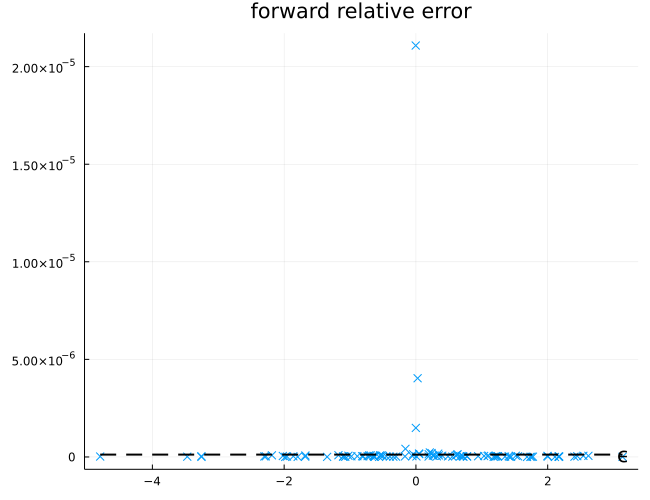

In [18]:
n_samples = 100;
x = randn(Float64, n_samples)
y = randn(Float64, n_samples)
z_true = x - y
z_fl32 = Float32.(x) - Float32.(y)
r = abs.(Float64.(z_fl32) - z_true) ./ abs.(z_true)
plot(z_true, r, st=:scatter, m=:x)
plot!([minimum(z_true),maximum(z_true)], eps(Float32)*[1,1], l=(2,:black,:dash), text=["", "ϵ"], ylim=1.1*eps(Float32), size=(650,500), title = "forward relative error")

### Stability

An algorithm $\tilde{f}$ is _stable_ if for each $x\in X$,

$$
\frac{\|\tilde{f}(x) - f(\tilde{x})\|}{\|f(\tilde{x})\|} = O(\epsilon_{\text{machine}})
$$

for some $\tilde{x}$ with

$$
\underbrace{\frac{\|\tilde x - x\|}{\|x\|}}_{\text{backward relative error}} = O(\epsilon_{\text{machine}}).
$$

> A stable algorithm gives nearly the right answer to nearly the right question.

### Subtraction with projection is stable

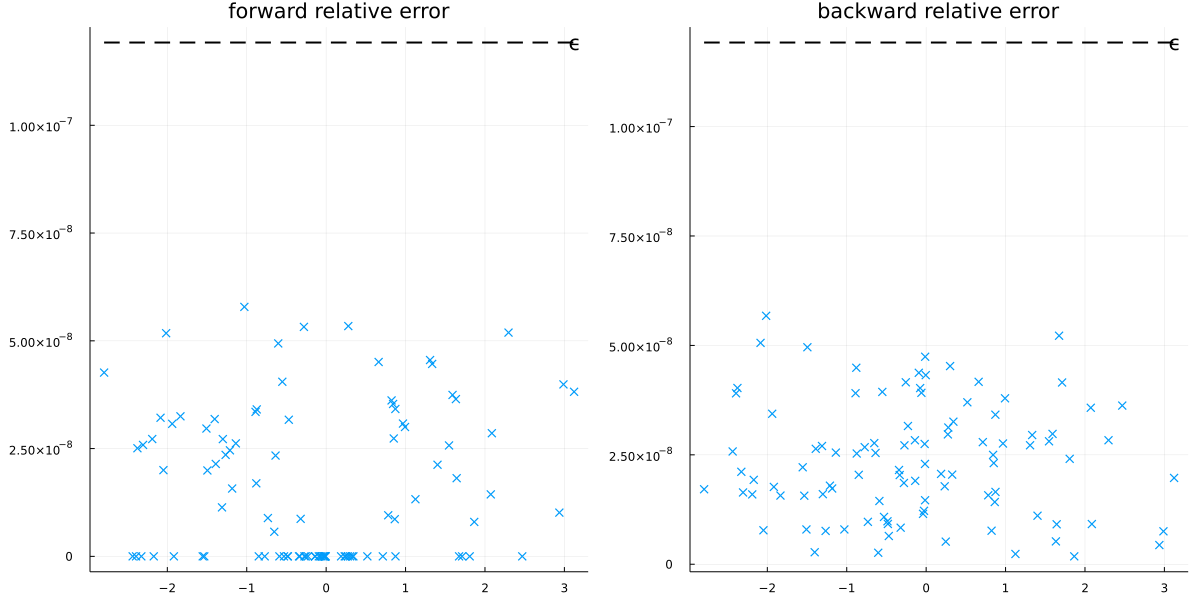

In [21]:
n_samples = 100;
x = randn(Float64, n_samples); x_32 = Float32.(x); x̃ = Float64.(x_32);
y = randn(Float64, n_samples); y_32 = Float32.(y); ỹ = Float64.(y_32);
z_true = x - y
z̃ = x̃ - ỹ
z_fl32 = x_32 - y_32
r̃ = abs.(Float64.(z_fl32) - z̃) ./ abs.(z̃)
e = max.(abs.(x - x̃), abs.(y - ỹ)) ./ max.(abs.(x), abs.(y))
p = plot(z_true, r̃, st=:scatter, m=:x)
plot!(p,[minimum(z_true),maximum(z_true)], eps(Float32)*[1,1], l=(2,:black,:dash), text=["", "ϵ"], ylim=1.1*eps(Float32), size=(650,500), title = "forward relative error")
q = plot(z_true, e, st=:scatter, m=:x)
plot!(q,[minimum(z_true),maximum(z_true)], eps(Float32)*[1,1], l=(2,:black,:dash), text=["", "ϵ"], ylim=1.1*eps(Float32), size=(650,500), title = "backward relative error")
plot(p,q,layout=(1,2), size=(1200,600))

### Backward Stability

An algorithm $\tilde{f}$ is _backward stable_ if for each $x\in X$,

$$\tilde{f}(x) = f(\tilde{x}) \quad\text{for some}\quad \tilde{x} \quad\text{with}\quad
\frac{\|\tilde x - x\|}{\|x\|} = O(\epsilon_{\text{machine}}).$$

> A backward stable algorithm gives exactly th right answer to nearly the right question.

### Floating point subtraction with projection is backward stable

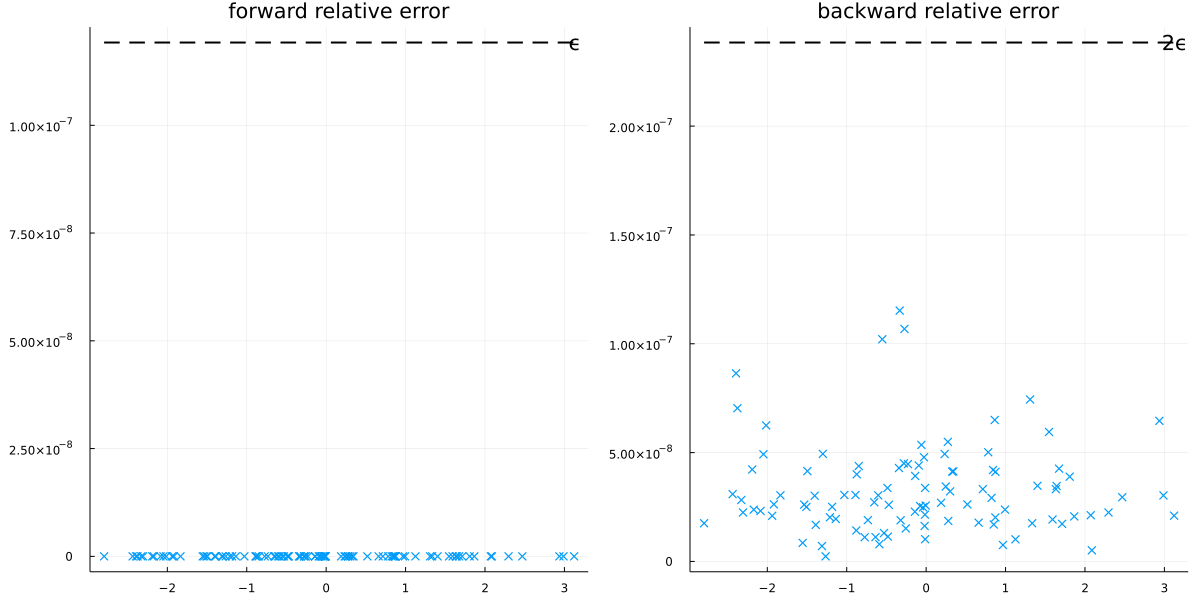

In [34]:
n_samples = 100;
x = randn(Float64, n_samples); x_32 = Float32.(x); x̃ = Float64.(x_32);
y = randn(Float64, n_samples); y_32 = Float32.(y); ỹ = Float64.(y_32);
z_fl32 = x_32 - y_32; z̃ = x̃ - ỹ
δ = z_fl32 - z̃;       x̃ .+= δ;    z̃ = x̃ - ỹ
r̃ = abs.(Float64.(z_fl32) - z̃) ./ abs.(z̃)
e = max.(abs.(x - x̃), abs.(y - ỹ)) ./ max.(abs.(x), abs.(y))
p = plot(z_true, r̃, st=:scatter, m=:x)
plot!(p,[minimum(z_true),maximum(z_true)], eps(Float32)*[1,1], l=(2,:black,:dash), text=["", "ϵ"], ylim=1.1*eps(Float32), size=(650,500), title = "forward relative error")
q = plot(z_true, e, st=:scatter, m=:x)
plot!(q,[minimum(z_true),maximum(z_true)], 2*eps(Float32)*[1,1], l=(2,:black,:dash), text=["", "2ϵ"], ylim=1.1*eps(Float32), size=(650,500), title = "backward relative error")
plot(p,q,layout=(1,2), size=(1200,600))

## The Meaning of $O(\epsilon_{\text{machine}})$

### The meaning of $O(g(t))$

$$f(t) = O(g(t))$$

if and only if there is a $C$ and $\rho$ such that for all $t$ closer to the limit than $\rho$ (if the limit is 0,  $t < \rho$)

$$
|f(t)| \leq C |g(t)|.
$$

### The meaning of uniform asymptotic bounds

$$f(s,t) = O(g(t))\quad \text{uniformly in }s$$

if and only if there is a $C$ and $\rho$ such that **for all $s$** and for all $t$ closer to the limit than $\rho$ (if the limit is 0,  $t < \rho$)

$$
|f(t)| \leq C |g(t)|.
$$

### Example

$$(\sin^2 t)(\sin^2 s) = O(t^2) \quad\text{uniformly in }s$$
$$(\sin^2 t)s^2 = O(t^2) \quad\text{nonuniformly in }s$$

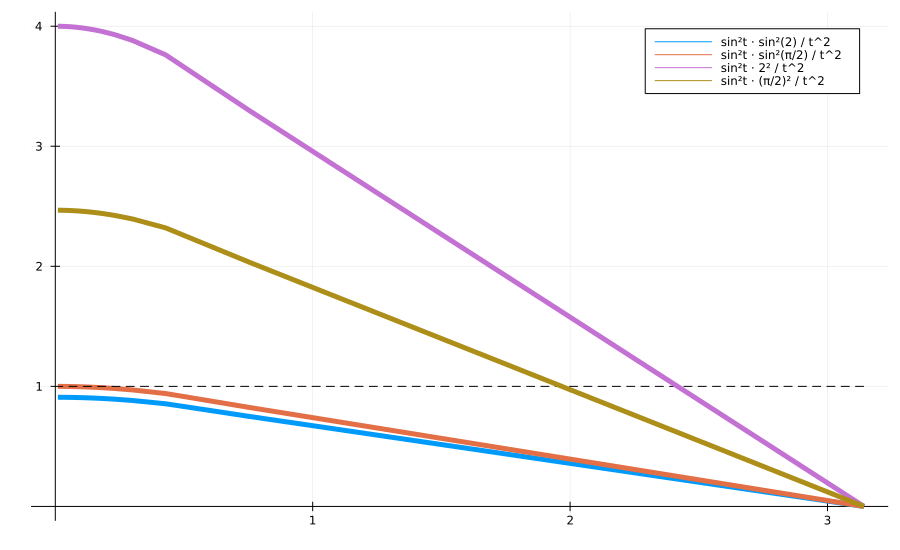

In [20]:
t = 1 ./ LinRange(1/π, 100, 100)
y_2 = sin.(t) .^ 2 .* sin.(2.0)
y_3 = sin.(t) .^ 2 .* sin.(π/2)
z_2 = sin.(t) .^ 2 .* 2.0^2
z_3 = sin.(t) .^ 2 .* (π/2)^2
p = plot(t, y_2 ./ (t .^ 2)
    , label = "sin²t ⋅ sin²(2) / t^2"
    , framestyle = :origin
)
plot!(p, t, y_3 ./ (t .^ 2)
    , label = "sin²t ⋅ sin²(π/2) / t^2"
    )
plot!(p, [t[1],t[end]], [1.0, 1.0]
    , l = (:black,:dash,1)
    )
plot!(p, t, z_2 ./ (t .^ 2)
    , label = "sin²t ⋅ 2² / t^2"
    )
plot!(p, t, z_3 ./ (t .^ 2)
    , label = "sin²t ⋅ (π/2)² / t^2"
    )

### The meaning of $O(\epsilon_{\text{machine}})$

We think of $\tilde{f}(x) = \tilde{f}(x, \epsilon_{\text{machine}})$ as though the algorithm could be run with the floating point precision of our choosing.

#### Example: accuracy

Our statement of accuracy could be restated as

$$
\frac{\|\tilde{f}(x,\epsilon_{\text{machine}}) - f(x)\|}{\|f(x)\|} = O(\epsilon_{\text{machine}})\quad\text{uniformly in }x.
$$

### Exercise

**T&B Exercise 14.1.**

Say whether these asymptotic statements are true or false, and give a short explanation why.

(a) $\mathrm{fl}(\pi) - \pi = O(\epsilon_{\text{machine}})$.

(g) $\mathrm{fl}(n\pi) - n\pi = O(\epsilon_{\text{machine}})$, uniformly for all integers $n$.

### What if the denominator is 0?

When we say

$$
\frac{\|\tilde{f}(x,\epsilon_{\text{machine}}) - f(x)\|}{\|f(x)\|} = O(\epsilon_{\text{machine}})\quad\text{uniformly in }x,
$$

we mean

$$
\|\tilde{f}(x,\epsilon_{\text{machine}}) - f(x)\| = O(\epsilon_{\text{machine}}\|f(x)\|)\quad\text{uniformly in }x.
$$

If $\|f(x)\| = 0$, then this mean there is a small enough $\epsilon_{\text{machine}}$ where 
$\tilde{f}(x,\epsilon_{\text{machine}}) = f(x).$

### Aside: the meaning of $o(g(t))$

$$f(t) = o(g(t))$$

if and only if **for every C > 0** there is a $\rho_C$ such that for all $t$ closer to the limit than $\rho$

$$|f(t)| \leq C |g(t)|.$$

$$\begin{aligned}
f(t) = o(g(t)) &\Rightarrow \lim_t \frac{|f(t)|}{|g(t)|} = 0.\\
f(t) = o(g(t)) &\Rightarrow f(t) = O(g(t)).\\
f(t) = O(g(t)) &\Rightarrow \lim\sup_t \frac{|f(t)|}{|g(t)|} \leq C < \infty.\\
f(t) = O(g(t)) &\not\Rightarrow \lim\sup_t \frac{|f(t)|}{|g(t)|} = 0.
\end{aligned}$$